## Set up

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
import torch
from torch import nn
import skorch
import math
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from torch.nn.utils import prune
from datetime import date
from datetime import datetime, timedelta
import os
import seaborn as sns

# from ESRNN import ESRNN
# from ESRNN.utils_evaluation import evaluate_prediction_owa
# from ESRNN.utils_visualization import plot_grid_prediction

root = os.getcwd()[-0:-7]
root

read_vif_values = False
run_hyper_params = False
train_lstm = False
train_statistical = True
forecast_start_date = date(2023, 1, 1)

y_name = "tgt_crd"
y_remove = "tgt_iron"
model_name = "lstm"

dat = pd.read_csv(root + "\\data\\dat.csv")
dat = dat.set_index("dte")
dat = dat.dropna() #data is pre-cleaned no no NA's should be present. This is to make sure.
dates = dat.iloc[:-100]
dates = dates[(dates.index >= str(forecast_start_date))].index
# dat = dat.drop("tgt_iron", axis=1)#.astype('float64')
dat.shape

import sys
sys.path.append('ESRNN-GPU')

In [3]:
%connect_info

{
  "shell_port": 64766,
  "iopub_port": 64767,
  "stdin_port": 64768,
  "control_port": 64770,
  "hb_port": 64769,
  "ip": "127.0.0.1",
  "key": "66b3e6b3-e53f8f24f9a31395dec5f47e",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "gpu2"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-b496ab78-6e93-4aa3-9d93-bd72f93b6baf.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


## Kernal Check

In [10]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [11]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7676120182123176638
 xla_global_id: -1]

In [12]:
import subprocess

try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception: # this command not being found can raise quite a few different errors depending on the configuration
    print('No Nvidia GPU in system!')

print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

Nvidia GPU detected!
False
True


In [13]:
#torch.set_default_device('cuda')

## Funtions

https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b

In [24]:
from train_test_split_custom import feature_label_split, train_val_test_split, train_val_test_split_date

In [15]:
# #Train Test Split
# from sklearn.model_selection import train_test_split

# def feature_label_split(df, target_col):
#     y = df[[target_col]]
#     X = df.drop(columns=[target_col])
#     return X, y

# def train_val_test_split(df, target_col, test_ratio):
#     val_ratio = test_ratio / (1 - test_ratio)
#     X, y = feature_label_split(df, target_col)
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_ratio, shuffle=False)
#     X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_ratio, shuffle=False)
#     return X_train, X_val, X_test, y_train, y_val, y_test

# def train_val_test_split_date(df, target_col, dte, val_days = 50, test_days = 50):
#     val_date = dte + timedelta(days=val_days)
#     test_max_date = val_date + timedelta(days=test_days)

#     X_train = df[df.index <= str(dte)]
#     X_val = df[(df.index > str(dte)) & (df.index <= str(val_date))]
#     X_test = df[(df.index > str(val_date)) & (df.index <= str(test_max_date))]

#     X_train, y_train = feature_label_split(X_train, target_col)
#     X_val, y_val = feature_label_split(X_val, target_col)
#     X_test, y_test = feature_label_split(X_test, target_col)
    
#     return X_train, X_val, X_test, y_train, y_val, y_test

https://www.kaggle.com/code/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch/notebook

In [16]:
#Subset Selection
def processSubset(feature_set, X, y):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

def forward(predictors, X, y):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X, y))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [17]:
def vif_correlation_subset(X_train, X_test, X_val, read_vif_values = False, verbose = True):

    from statsmodels.stats.outliers_influence import variance_inflation_factor

    if read_vif_values:
        X_train_vif = pd.read_csv("X_train_vif.csv", index_col = 0)
        X_train = X_train[X_train_vif.columns]  
        X_test = X_test[X_train_vif.columns]        
        X_val = X_val[X_train_vif.columns] 

    else:  
        # Create correlation matrix
        corr_matrix = X_train.corr().abs()

        # Select upper triangle of correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        # Find features with correlation greater than 0.95
        to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

        # Drop features 
        X_train.drop(to_drop, axis=1, inplace=True)

        #https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

        X_train_vif = X_train
        # vif_cols = list(X_train.columns)
        # vif_values = X_train.values

        for index, col in enumerate(X_train.columns):
            if verbose:
                print(col)
                print(index)

            vif_data = pd.DataFrame()
            vif_data["VIF"] = [variance_inflation_factor(X_train_vif.values, i)
                              for i in range(len(X_train_vif.columns))]
            vif_data["feature"] = X_train_vif.columns  

            feature = vif_data[vif_data["feature"] == col]
            if verbose:
                print(feature)

            if feature["VIF"].values[0] > 10:
                #vif_cols.remove(feature["feature"].values[0])  
                X_train = X_train.drop([feature["feature"].values[0]], axis=1)
                if verbose:
                    print("Removing " + feature["feature"].values[0])
                    #print(X_Train)

            X_train.head(5).to_csv("X_train_vif.csv")
 
        X_test = X_test[X_train.columns]        
        X_val = X_val[X_train.columns] 
    
    return(X_train, X_test, X_val)

In [18]:
def fwd_subset(X_train, X_test, X_val, y_train, y_name, verbose = True, read_subset_values = False):
    
    if read_subset_values:
        X_train_subset1 = pd.read_csv("X_train_subset.csv", index_col = 0)
        X_train_subset = X_train[X_train_subset1.columns]  
        X_test_subset = X_test[X_train_subset1.columns]        
        X_val_subset = X_val[X_train_subset1.columns] 
        from statsmodels.regression.linear_model import OLSResults
        reg_model = OLSResults.load("reg_model.pickle")
        subsets = pd.read_csv("subsets.csv", index_col = 0)

    else:
        models_fwd = pd.DataFrame(columns=["RSS", "model"])

        tic = time.time()
        predictors = []

        for i in range(1,len(X_train.columns)+1):    
            models_fwd.loc[i] = forward(predictors, X_train, y_train[y_name])
            predictors = models_fwd.loc[i]["model"].model.exog_names

        toc = time.time()

        if verbose:
            print("Total elapsed time:", (toc-tic), "seconds.")

        d = []
        for i in range(1, len(models_fwd)):
            d.append({"model" : i, "r_sq": models_fwd.loc[i, "model"].rsquared})

        subsets = pd.DataFrame(d)
        subsets["diff"] = subsets["r_sq"].diff()

        pred_subset = min(subsets[subsets["diff"] < 0.0001].index)
        pred_subset

        reg_model = models_fwd.loc[pred_subset, "model"]
        if verbose:
            print(models_fwd.loc[pred_subset, "model"].summary())

        subset_cols = reg_model.params.index.tolist()
        #'quant_bef_low_high_range', taken out due to high VIF
        X_train_subset = X_train[subset_cols]
        X_test_subset = X_test[subset_cols]
        X_val_subset = X_val[subset_cols]
        
        reg_model.save("reg_model.pickle")
        X_train_subset.head(5).to_csv("X_train_subset.csv")
        subsets.to_csv("subsets.csv")
    
    return(X_train_subset, X_test_subset, X_val_subset, reg_model, subsets)

## Models

In [19]:
# Build LSTM model
#####################
# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    

In [20]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNN, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [21]:

class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.gru(x, (h0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [22]:
def prune_model_l1_unstructured(model, layer_type, proportion):
    for module in model.modules():
        if isinstance(module, layer_type):
            prune.l1_unstructured(module, 'weight', proportion)
            prune.remove(module, 'weight')
    return model

## Preparation

#### Processing

In [23]:
# #Train test validation splits
# #X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(ob, y_name, 0.2)
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split_date(dat, y_name, dte = forecast_start_date)
# y_val_low = y_val
# print("X_train: " + str(X_train.shape) + " " + str(min(X_train.index)) + ">" + str(max(X_train.index)))
# print("X_test: " + str(X_test.shape)+ " " + str(min(X_test.index)) + ">" + str(max(X_test.index)))
# print("X_val: " + str(X_val.shape)+ " " + str(min(X_val.index)) + ">" + str(max(X_val.index)))
# print("y_train: " + str(y_train.shape)+ " " + str(min(y_train.index)) + ">" + str(max(y_train.index)))
# print("y_test: " + str(y_test.shape)+ " " + str(min(y_test.index)) + ">" + str(max(y_test.index)))
# print("y_val: " + str(y_val.shape)+ " " + str(min(y_val.index)) + ">" + str(max(y_val.index)))

NameError: name 'train_val_test_split_date' is not defined

In [ ]:
# import datetime
# forecast_start_date + datetime.timedelta(days=1)

### Exploration

Data visualisation check, although in quantile form the data has an odd structure. 

In [ ]:
fig, ax = plt.subplots()
ax.plot(y_train.index, y_train.values)
ax.grid()
plt.xticks(np.arange(0,y_train.shape[0],math.floor(y_train.shape[0]/4)))
plt.show()

Data against one of the key features yesterdays mean rolled value in quantile form.

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_train['WB_CRUDE_BRENT'], y_train)
ax.grid()
plt.show()

In [ ]:
import seaborn as sns
# sns.pairplot(ob)

Look at correlation of the key feature against target 

In [ ]:
# calculate the spearmans's correlation between two variables
from numpy.random import randn
from numpy.random import seed
from scipy.stats import spearmanr
# seed random number generator
# calculate spearman's correlation
# corr, _ = spearmanr(X_train['quant_bef_Last_Rolled'], y_train)
# print('Spearmans correlation: %.3f' % corr)

### VIF

### Subsetting

http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html

 Create a subset of the best features to feed into the networks to speed up training time.

In [ ]:
# models_fwd = pd.DataFrame(columns=["RSS", "model"])

# tic = time.time()
# predictors = []

# for i in range(1,len(X_train.columns)+1):    
#     models_fwd.loc[i] = forward(predictors, X_train, y_train[y_name])
#     predictors = models_fwd.loc[i]["model"].model.exog_names

# toc = time.time()
# print("Total elapsed time:", (toc-tic), "seconds.")

In [ ]:
# d = []
# for i in range(1, len(models_fwd)):
#     d.append({"model" : i, "r_sq": models_fwd.loc[i, "model"].rsquared})
    
# subsets = pd.DataFrame(d)
# subsets["diff"] = subsets["r_sq"].diff()

# pred_subset = min(subsets[subsets["diff"] < 0.0001].index)
# pred_subset

In [ ]:
# plt.plot(subsets["r_sq"], label="r squared")
# plt.legend()
# plt.show()

In [ ]:
# reg_model_low = models_fwd.loc[pred_subset, "model"]
# print(models_fwd.loc[pred_subset, "model"].summary())

In [ ]:
# subset_cols = reg_model_low.params.index.tolist()
# #'quant_bef_low_high_range', taken out due to high VIF
# X_train_subset = X_train[subset_cols]
# X_test_subset = X_test[subset_cols]
# X_val_subset = X_val[subset_cols]
# #Nieve Model
# # y_pred_reg_low = reg_model_low.predict(X_val_subset) 
# # y_pred_reg_low

Recheck on the VIF

At this point the X_train_subset or the orginal X_train can be fed into the tensors depending on how one wants to train the networks

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# X_train_arr = scaler.fit_transform(X_train_subset)
# X_val_arr = scaler.transform(X_val_subset)
# X_test_arr = scaler.transform(X_test_subset)

# y_train_arr = scaler.fit_transform(y_train)
# y_val_arr = scaler.transform(y_val)
# y_test_arr = scaler.transform(y_test)

# # make training and test sets in torch
# X_train_subset_tensor = torch.from_numpy(X_train_arr).type(torch.Tensor)
# X_test_subset_tensor = torch.from_numpy(X_test_arr).type(torch.Tensor)
# X_val_subset_tensor = torch.from_numpy(X_val_arr).type(torch.Tensor)
# y_train_tensor = torch.from_numpy(y_train_arr).type(torch.Tensor)
# y_test_tensor = torch.from_numpy(y_test_arr).type(torch.Tensor)
# y_val_tensor = torch.from_numpy(y_val_arr).type(torch.Tensor)

# X_train_subset_tensor = X_train_subset_tensor[:,:,None]
# #y_train_tensor = y_train_tensor[:,None]
# X_test_subset_tensor = X_test_subset_tensor[:,:,None]
# #y_test_tensor = y_test_tensor[:,None]
# X_val_subset_tensor = X_val_subset_tensor[:,:,None]
# #y_val_tensor = y_val_tensor[:,None]

# print('x_train.shape = ',X_train_subset_tensor.shape)
# print('y_train.shape = ',y_train_tensor.shape)
# print('x_test.shape = ',X_test_subset_tensor.shape)
# print('y_test.shape = ',y_test_tensor.shape)
# print('x_val.shape = ',X_val_subset_tensor.shape)
# print('y_val.shape = ',y_val_tensor.shape)

Trains the regression model

In [ ]:
# y_pred_train_reg_low = reg_model_low.predict(X_train_arr) 
# y_pred_test_reg_low = reg_model_low.predict(X_test_arr) 
# y_pred_val_reg_low = reg_model_low.predict(X_val_arr) 

# trainScore = math.sqrt(mean_squared_error(y_train, y_pred_train_reg_low))
# print('Regression Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(y_test, y_pred_test_reg_low))
# print('Regression Test Score: %.2f RMSE' % (testScore))
# valScore = math.sqrt(mean_squared_error(y_val, y_pred_val_reg_low))
# print('Regression Validation Score: %.2f RMSE' % (valScore))

## Modelling

## HyperOpt

https://discuss.pytorch.org/t/hyperparameter-using-skorch-how-to-set-some-optimizer-as-parameter/38057

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://skorch.readthedocs.io/en/stable/regressor.html

This creates two set of parameters. The outer parameters are fed into the LSTM creation and the inner paramterers are fed into the neural net regressor. Items are added to each of the lists and run for the number of required epochs. Althought it doesnt not produce the best model the epochs are held to 100 to save training time. 

In [ ]:
from itertools import product
outer_params = {
        'hidden_dim': [32, 16, 8],
        'num_layers': [2,  4],
        'dropout_prob': [0.2, 0.4],
        'criterion': [torch.nn.L1Loss(), torch.nn.MSELoss()],
        'prune':[0.2, 0.4]
    }


def expand_grid(dictionary):
    return(pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns=dictionary.keys()))

outer_params_grid = expand_grid(outer_params).iloc[11]
outer_params_grid

In [ ]:
#TODO, change to subset tensors which might work better
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetRegressor

if run_hyper_params == True:
    
    # #Train test validation splits
    y_name = "tgt_crd"
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split_date(dat, y_name, dte = forecast_start_date)
    print("X_train: " + str(X_train.shape) + " " + str(min(X_train.index)) + ">" + str(max(X_train.index)))
    print("X_test: " + str(X_test.shape)+ " " + str(min(X_test.index)) + ">" + str(max(X_test.index)))
    print("X_val: " + str(X_val.shape)+ " " + str(min(X_val.index)) + ">" + str(max(X_val.index)))
    print("y_train: " + str(y_train.shape)+ " " + str(min(y_train.index)) + ">" + str(max(y_train.index)))
    print("y_test: " + str(y_test.shape)+ " " + str(min(y_test.index)) + ">" + str(max(y_test.index)))
    print("y_val: " + str(y_val.shape)+ " " + str(min(y_val.index)) + ">" + str(max(y_val.index)))
    
    X_train_vif, X_test_vif, X_val_vif = vif_correlation_subset(X_train, X_test, X_val, 
                                                                read_vif_values = True, verbose = True)
    
    X_train_subset, X_test_subset, X_val_subset, reg_model, subsets = fwd_subset(X_train_vif, X_test_vif, X_val_vif, 
                                                             y_train, y_name, verbose = True, 
                                                                        read_subset_values = True)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    X_train_arr = scaler.fit_transform(X_train_subset)
    X_val_arr = scaler.transform(X_val_subset)
    X_test_arr = scaler.transform(X_test_subset)

    y_train_arr = scaler.fit_transform(y_train)
    y_val_arr = scaler.transform(y_val)
    y_test_arr = scaler.transform(y_test)
    
    # make training and test sets in torch
    X_train_subset_tensor = torch.from_numpy(X_train_arr).type(torch.Tensor)
    X_test_subset_tensor = torch.from_numpy(X_test_arr).type(torch.Tensor)
    X_val_subset_tensor = torch.from_numpy(X_val_arr).type(torch.Tensor)
    y_train_tensor = torch.from_numpy(y_train_arr).type(torch.Tensor)
    y_test_tensor = torch.from_numpy(y_test_arr).type(torch.Tensor)
    y_val_tensor = torch.from_numpy(y_val_arr).type(torch.Tensor)
    
    X_train_subset_tensor = X_train_subset_tensor[:,:,None]
    X_test_subset_tensor = X_test_subset_tensor[:,:,None]
    X_val_subset_tensor = X_val_subset_tensor[:,:,None]
    
    start_time = time.time()   
    output = []
#     outer_params = {
#         'hidden_dim': [32, 32, 24, 24, 16, 16],
#         'num_layers': [2, 2, 4 , 4],
#         'dropout_prob': [0.2, 0.2, 0.2, 0.2],
#         'criterion': [torch.nn.L1Loss(), torch.nn.L1Loss(),
#                      torch.nn.L1Loss(), torch.nn.MSELoss()],
#         'prune':[0.2, 0.4, 0.4, 0.4]
#     }
    
    outer_params = outer_params_grid

    inner_params = {
        'lr': [0.1],
        'max_epochs': [200]#list(range(300,1000, 200))
    }

    for idx, x in enumerate(outer_params['hidden_dim']):
        print("Hidden Dim:" + str(outer_params['hidden_dim'][idx]) + 
              " Layers:" + str(outer_params['num_layers'][idx]) + 
             " Dropout:" + str(outer_params['dropout_prob'][idx]) + 
             " Criterion:" + str(outer_params['criterion'][idx]))

        net = LSTM(input_dim = 1,
                    hidden_dim = outer_params['hidden_dim'][idx],
                    num_layers = outer_params['num_layers'][idx], 
                    output_dim = 1,
                    dropout_prob = outer_params['dropout_prob'][idx])

        net = prune_model_l1_unstructured(net, nn.Conv2d, outer_params['prune'][idx])

        net = NeuralNetRegressor(net,
                                 verbose=1, 
                                criterion = outer_params['criterion'][idx],
                                optimizer= torch.optim.Adam)

        #criterion = nn.L1Loss()
        #criteion = nn.MSELoss()
        #optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  
        #optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

#         X_trf = np.array(X_train)
#         y_trf = np.array(y_train).reshape(-1, 1)

        gs = GridSearchCV(net, inner_params, refit=False, scoring='r2', verbose=1, error_score='raise', cv=2, n_jobs = -1)

        gs.fit(X_train_subset_tensor, y_train_tensor)

        output.append("Hidden Dim:" + str(list(outer_params.values[idx])[0]) +
                      " Num Layers:" + str(list(outer_params.values[idx])[1]) +
                      " Dropout:" + str(list(outer_params.values[idx])[2]) +
                      " Criterion:" + str(list(outer_params.values[idx])[3]) +
                      " Prune:" + str(list(outer_params.values[idx])[4]) +
                      str(gs.best_params_) + 
                      " Error: " + str(round(gs.cv_results_['mean_test_score'][gs.best_index_],2)))

    print("--- %s seconds ---" % (time.time() - start_time))
    print(output)
    print(str(gs.best_params_) + " with " + str(round(gs.cv_results_['mean_test_score'][gs.best_index_],2)))

The best params here is the last one from the outer params loop and might not match the true best params. Output needs to be looked at to see which in the full list were the best.

## Y only

## Regression

In [43]:
def train_stat(
            dat,
            dte,
            y_name,
            y_remove,
            step,
            model_name,
            run_vif = True,
            run_fwd_selection = True,
            verbose = True,
            read_vif_values = False,
            read_subset_values = False,
            val_days = 50,
            test_days = 50):
    
    #Split data
    #Train test validation splits
    dat = dat.copy().drop(y_remove, axis=1)#.astype('float64')
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split_date(df = dat, target_col = y_name, dte = dte,
                                                                              val_days = val_days, test_days = val_days)
    
    if verbose == True:
        print(dte)
        print("X_train: " + str(X_train.shape) + " " + str(min(X_train.index)) + ">" + str(max(X_train.index)))
        print("X_test: " + str(X_test.shape)+ " " + str(min(X_test.index)) + ">" + str(max(X_test.index)))
        print("X_val: " + str(X_val.shape)+ " " + str(min(X_val.index)) + ">" + str(max(X_val.index)))
        print("y_train: " + str(y_train.shape)+ " " + str(min(y_train.index)) + ">" + str(max(y_train.index)))
        print("y_test: " + str(y_test.shape)+ " " + str(min(y_test.index)) + ">" + str(max(y_test.index)))
        print("y_val: " + str(y_val.shape)+ " " + str(min(y_val.index)) + ">" + str(max(y_val.index)))


    #Create tensors from subset of data
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler()
    X_train_arr = scaler.fit_transform(X_train_subset)
    X_val_arr = scaler.transform(X_val_subset)
    X_test_arr = scaler.transform(X_test_subset)

    # y_train_arr = scaler.fit_transform(y_train)
    # y_val_arr = scaler.transform(y_val)
    # y_test_arr = scaler.transform(y_test)
    
    #Subset data 
    if run_vif:
       X_train, X_test, X_val = vif_correlation_subset(X_train_arr, X_test_arr, X_val_arr, 
                                                                read_vif_values = read_vif_values, verbose = verbose)

    if run_fwd_selection:
        X_train, X_test, X_val, reg_model, subsets = fwd_subset(X_train_vif, X_test_vif, X_val_vif, 
                                                             y_train, y_name, verbose = verbose, 
                                                            read_subset_values = read_subset_values)

    if model_name == "reg":
        y_pred_train_reg = reg_model.predict(X_train_arr) 
        y_pred_test_reg = reg_model.predict(X_test_arr) 
        y_pred_val_reg = reg_model.predict(X_val_arr) 
        
        import math
        from sklearn.metrics import mean_squared_error
        trainScoreReg = math.sqrt(mean_squared_error(y_train, y_pred_train_reg))
        testScoreReg = math.sqrt(mean_squared_error(y_test, y_pred_test_reg))
        valScoreReg = math.sqrt(mean_squared_error(y_val, y_pred_val_reg))
        
        if verbose == True:
            print('Regression Train Score: %.2f RMSE' % (trainScoreReg))
            print('Regression Test Score: %.2f RMSE' % (testScoreReg))
            print('Regression Validation Score: %.2f RMSE' % (valScoreReg))
            
            plt.plot(subsets["r_sq"], label="r squared")
            plt.legend()
            plt.show()


    err_row = pd.DataFrame(data = {"reg_train":trainScoreReg,"reg_test":testScoreReg, "reg_val":valScoreReg#,
            #"hist":hist,"hist_test":hist_test,"y_test_pred":y_test_pred, "y_val_pred":y_val_pred
                                  }, index = [str(dte)])
        
    fcst = pd.DataFrame(data = {"dte" : y_val.index.to_list(), "step":[step] * len(y_pred_val_reg), 
                                "y_pred": y_pred_val_reg.flatten(), "y_val": y_val.values.flatten()})

    fcst.index = fcst["step"].astype(str) + "_" + fcst["dte"]

    return(y_pred_test_reg, y_pred_val_reg, err_row, fcst)


2023-01-03 00:00:00
X_train: (3066, 312) 2010-10-26>2023-01-03
X_test: (35, 312) 2023-02-23>2023-04-13
X_val: (34, 312) 2023-01-04>2023-02-22
y_train: (3066, 1) 2010-10-26>2023-01-03
y_test: (35, 1) 2023-02-23>2023-04-13
y_val: (34, 1) 2023-01-04>2023-02-22
Processed  48 models on 1 predictors in 0.046172142028808594 seconds.
Processed  47 models on 2 predictors in 0.052465200424194336 seconds.
Processed  46 models on 3 predictors in 0.05447101593017578 seconds.
Processed  45 models on 4 predictors in 0.06482219696044922 seconds.
Processed  44 models on 5 predictors in 0.07258319854736328 seconds.
Processed  43 models on 6 predictors in 0.07682228088378906 seconds.
Processed  42 models on 7 predictors in 0.08600330352783203 seconds.
Processed  41 models on 8 predictors in 0.10513877868652344 seconds.
Processed  40 models on 9 predictors in 0.10223746299743652 seconds.
Processed  39 models on 10 predictors in 0.11682415008544922 seconds.
Processed  38 models on 11 predictors in 0.117836

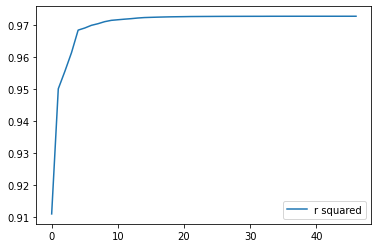

C:\Users\lawre\AppData\Local\Temp\ipykernel_24108\1006258410.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_list = pd.concat([model_list, err_row])
C:\Users\lawre\AppData\Local\Temp\ipykernel_24108\1006258410.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fcst_all = pd.concat([fcst_all, fcst])


2023-01-10 00:00:00
X_train: (3071, 312) 2010-10-26>2023-01-10
X_test: (35, 312) 2023-03-02>2023-04-20
X_val: (34, 312) 2023-01-11>2023-03-01
y_train: (3071, 1) 2010-10-26>2023-01-10
y_test: (35, 1) 2023-03-02>2023-04-20
y_val: (34, 1) 2023-01-11>2023-03-01
Processed  48 models on 1 predictors in 0.04986715316772461 seconds.
Processed  47 models on 2 predictors in 0.06461548805236816 seconds.
Processed  46 models on 3 predictors in 0.06905651092529297 seconds.
Processed  45 models on 4 predictors in 0.0853722095489502 seconds.
Processed  44 models on 5 predictors in 0.07855629920959473 seconds.
Processed  43 models on 6 predictors in 0.09078741073608398 seconds.
Processed  42 models on 7 predictors in 0.09556245803833008 seconds.
Processed  41 models on 8 predictors in 0.09815812110900879 seconds.
Processed  40 models on 9 predictors in 0.13257455825805664 seconds.
Processed  39 models on 10 predictors in 0.12720298767089844 seconds.
Processed  38 models on 11 predictors in 0.125606298

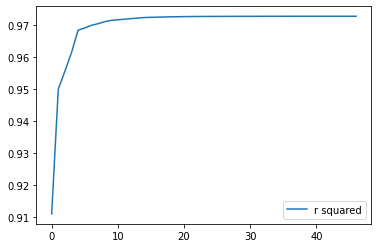

2023-01-18 00:00:00
X_train: (3076, 312) 2010-10-26>2023-01-18
X_test: (35, 312) 2023-03-10>2023-04-28
X_val: (35, 312) 2023-01-19>2023-03-09
y_train: (3076, 1) 2010-10-26>2023-01-18
y_test: (35, 1) 2023-03-10>2023-04-28
y_val: (35, 1) 2023-01-19>2023-03-09
Processed  48 models on 1 predictors in 0.04454851150512695 seconds.
Processed  47 models on 2 predictors in 0.045038461685180664 seconds.
Processed  46 models on 3 predictors in 0.06006264686584473 seconds.
Processed  45 models on 4 predictors in 0.06256699562072754 seconds.
Processed  44 models on 5 predictors in 0.06740164756774902 seconds.
Processed  43 models on 6 predictors in 0.0714409351348877 seconds.
Processed  42 models on 7 predictors in 0.0779416561126709 seconds.
Processed  41 models on 8 predictors in 0.08669161796569824 seconds.
Processed  40 models on 9 predictors in 0.09659504890441895 seconds.
Processed  39 models on 10 predictors in 0.10907363891601562 seconds.
Processed  38 models on 11 predictors in 0.107787132

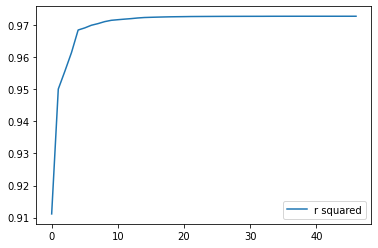

2023-01-25 00:00:00
X_train: (3081, 312) 2010-10-26>2023-01-25
X_test: (35, 312) 2023-03-17>2023-05-05
X_val: (35, 312) 2023-01-26>2023-03-16
y_train: (3081, 1) 2010-10-26>2023-01-25
y_test: (35, 1) 2023-03-17>2023-05-05
y_val: (35, 1) 2023-01-26>2023-03-16
Processed  48 models on 1 predictors in 0.042037010192871094 seconds.
Processed  47 models on 2 predictors in 0.047083139419555664 seconds.
Processed  46 models on 3 predictors in 0.06310486793518066 seconds.
Processed  45 models on 4 predictors in 0.06278657913208008 seconds.
Processed  44 models on 5 predictors in 0.06556940078735352 seconds.
Processed  43 models on 6 predictors in 0.07423734664916992 seconds.
Processed  42 models on 7 predictors in 0.07948803901672363 seconds.
Processed  41 models on 8 predictors in 0.08651471138000488 seconds.
Processed  40 models on 9 predictors in 0.09430837631225586 seconds.
Processed  39 models on 10 predictors in 0.1070554256439209 seconds.
Processed  38 models on 11 predictors in 0.1101076

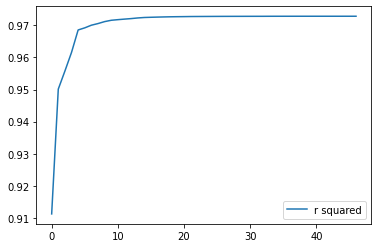

2023-02-01 00:00:00
X_train: (3086, 312) 2010-10-26>2023-02-01
X_test: (35, 312) 2023-03-24>2023-05-12
X_val: (35, 312) 2023-02-02>2023-03-23
y_train: (3086, 1) 2010-10-26>2023-02-01
y_test: (35, 1) 2023-03-24>2023-05-12
y_val: (35, 1) 2023-02-02>2023-03-23
Processed  48 models on 1 predictors in 0.043543338775634766 seconds.
Processed  47 models on 2 predictors in 0.045197248458862305 seconds.
Processed  46 models on 3 predictors in 0.05805516242980957 seconds.
Processed  45 models on 4 predictors in 0.06079840660095215 seconds.
Processed  44 models on 5 predictors in 0.06607437133789062 seconds.
Processed  43 models on 6 predictors in 0.07122993469238281 seconds.
Processed  42 models on 7 predictors in 0.07835102081298828 seconds.
Processed  41 models on 8 predictors in 0.08516836166381836 seconds.
Processed  40 models on 9 predictors in 0.08960676193237305 seconds.
Processed  39 models on 10 predictors in 0.1052091121673584 seconds.
Processed  38 models on 11 predictors in 0.1076171

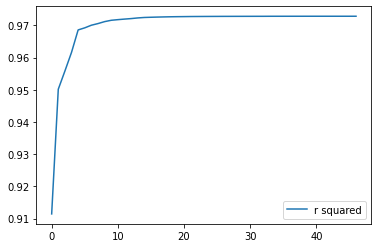

In [50]:
if train_statistical == True:
    fcst_all = pd.DataFrame(columns = ["dte", "step", "y_pred", "y_val"])
    model_list = pd.DataFrame(columns = ["reg_train", "reg_test", "reg_val"])
    model_name = "reg"
    
    for i, dte_str in enumerate(dates[::5]):
        dte = datetime.strptime(dte_str, "%Y-%m-%d")
        y_test_pred, y_val_pred, err_row, fcst = train_stat(dat = dat, dte = dte, step = i,
                                                         y_name = y_name, y_remove = y_remove,
                                                        run_vif = True, 
                                                        run_fwd_selection = True,
                                                        read_vif_values = True,
                                                        read_subset_values = False,
                                                        verbose = True,
                                                        model_name = model_name)

        model_list = pd.concat([model_list, err_row])
        fcst_all = pd.concat([fcst_all, fcst])

    model_list.to_csv(y_name + "_" + model_name + "_output_model.csv")
    fcst_all.to_csv(y_name + "_" + model_name +"_fcst_all.csv")

    model_list

In [29]:
train_stat

<function __main__.train_stat(dat, dte, y_name, y_remove, step, model_name, run_vif=True, run_fwd_selection=True, verbose=True, val_days=50, test_days=50)>

## Train Neural

Trains LSTM with the parameters found from the hyperparameter optimisation

In [29]:
def train_net(
            dat,
            dte,
            y_name,
            y_remove,
            step,
            model_name = "lstm",
            input_dim = 1,
            hidden_dim = 32,
            num_layers = 4,
            output_dim = 1,
            learning_rate = 0.1,
            weight_decay = 0.000001,
            dropout = 0.2,
            prune_prop = 0.2,
            num_epochs = 200,
            read_vif_values = False,
            verbose = True,
            read_subset_values = False,
            val_days = 50,
            test_days = 50):
    
    #Split data
    #Train test validation splits
    dat = dat.copy().drop(y_remove, axis=1)#.astype('float64')
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split_date(df = dat, target_col = y_name, dte = dte,
                                                                              val_days = val_days, test_days = val_days)
    
    if verbose == True:
        print(dte)
        print("X_train: " + str(X_train.shape) + " " + str(min(X_train.index)) + ">" + str(max(X_train.index)))
        print("X_test: " + str(X_test.shape)+ " " + str(min(X_test.index)) + ">" + str(max(X_test.index)))
        print("X_val: " + str(X_val.shape)+ " " + str(min(X_val.index)) + ">" + str(max(X_val.index)))
        print("y_train: " + str(y_train.shape)+ " " + str(min(y_train.index)) + ">" + str(max(y_train.index)))
        print("y_test: " + str(y_test.shape)+ " " + str(min(y_test.index)) + ">" + str(max(y_test.index)))
        print("y_val: " + str(y_val.shape)+ " " + str(min(y_val.index)) + ">" + str(max(y_val.index)))
    
    #Subset data 
    X_train_vif, X_test_vif, X_val_vif = vif_correlation_subset(X_train, X_test, X_val, 
                                                                read_vif_values = read_vif_values, verbose = verbose)
    
    X_train_subset, X_test_subset, X_val_subset, reg_model, subsets = fwd_subset(X_train_vif, X_test_vif, X_val_vif, 
                                                             y_train, y_name, verbose = verbose, 
                                                                        read_subset_values = read_subset_values)

    #Create tensors from subset of data
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler()
    X_train_arr = scaler.fit_transform(X_train_subset)
    X_val_arr = scaler.transform(X_val_subset)
    X_test_arr = scaler.transform(X_test_subset)

    y_train_arr = scaler.fit_transform(y_train)
    y_val_arr = scaler.transform(y_val)
    y_test_arr = scaler.transform(y_test)
    
    y_pred_train_reg = reg_model.predict(X_train) 
    y_pred_test_reg = reg_model.predict(X_test) 
    y_pred_val_reg = reg_model.predict(X_val) 
    
    import math
    from sklearn.metrics import mean_squared_error
    trainScoreReg = math.sqrt(mean_squared_error(y_train, y_pred_train_reg))
    testScoreReg = math.sqrt(mean_squared_error(y_test, y_pred_test_reg))
    valScoreReg = math.sqrt(mean_squared_error(y_val, y_pred_val_reg))
    
    if verbose == True:
        print('Regression Train Score: %.2f RMSE' % (trainScoreReg))
        print('Regression Test Score: %.2f RMSE' % (testScoreReg))
        print('Regression Validation Score: %.2f RMSE' % (valScoreReg))
        
        plt.plot(subsets["r_sq"], label="r squared")
        plt.legend()
        plt.show()

    # make training and test sets in torch
    X_train_subset_tensor = torch.from_numpy(X_train_arr).type(torch.Tensor)
    X_test_subset_tensor = torch.from_numpy(X_test_arr).type(torch.Tensor)
    X_val_subset_tensor = torch.from_numpy(X_val_arr).type(torch.Tensor)
    y_train_tensor = torch.from_numpy(y_train_arr).type(torch.Tensor)
    y_test_tensor = torch.from_numpy(y_test_arr).type(torch.Tensor)
    y_val_tensor = torch.from_numpy(y_val_arr).type(torch.Tensor)

    X_train_subset_tensor = X_train_subset_tensor[:,:,None]
    X_test_subset_tensor = X_test_subset_tensor[:,:,None]
    X_val_subset_tensor = X_val_subset_tensor[:,:,None]

    if verbose == True:
        print('x_train.shape = ',X_train_subset_tensor.shape)
        print('y_train.shape = ',y_train_tensor.shape)
        print('x_test.shape = ',X_test_subset_tensor.shape)
        print('y_test.shape = ',y_test_tensor.shape)
        print('x_val.shape = ',X_val_subset_tensor.shape)
        print('y_val.shape = ',y_val_tensor.shape)

    if model_name == "lstm":
        model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
                  num_layers=num_layers, dropout_prob = dropout)
    elif model_name == "gru":
        model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
                    num_layers=num_layers)
    elif model_name == "rnn":
        model = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
                          layer_dim=num_layers, dropout_prob = dropout)

    model = prune_model_l1_unstructured(model, nn.Conv2d, prune_prop)

    loss_fn = torch.nn.L1Loss()

    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    if verbose == True:
        print(model)
        print(len(list(model.parameters())))
        for i in range(len(list(model.parameters()))):
            print(list(model.parameters())[i].size())
        
    model = prune_model_l1_unstructured(model, nn.Conv2d, prune_prop)

    # Train model
    #####################
    hist = np.zeros(num_epochs)
    hist_test = np.zeros(num_epochs)
    look_back = 10 # choose sequence length

    # Number of steps to unroll
    seq_dim = look_back-1  

    start_time = time.time() 
    for t in range(num_epochs):
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        #model.hidden = model.init_hidden()

        # Forward pass
        y_train_pred = model(X_train_subset_tensor)
        y_test_pred = model(X_test_subset_tensor)

        loss = loss_fn(y_train_pred, y_train_tensor)
        loss_test = loss_fn(y_test_pred, y_test_tensor)
        if verbose == True:
            if t % 50 == 0 and t !=0:
                print("Epoch ", t, "MSE: ", loss.item())
                print("Epoch ", t, "Test MSE: ", loss_test.item())
        hist[t] = loss.item()
        hist_test[t] = loss_test.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
    
    if verbose == True:
        print("--- %s seconds ---" % (time.time() - start_time))
     
    if verbose == True:
        plt.plot(hist, label="Training loss")
        plt.plot(hist_test, label="Test loss")
        plt.legend()
        plt.title(str(model) + " Loss")
        plt.savefig('lstm_loss_low.png')
        plt.show()

    # make test predictions
    y_test_pred = model(X_test_subset_tensor)

    # invert predictions
    y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
    y_train_det = scaler.inverse_transform(y_train_tensor.detach().numpy())
    y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
    y_test_det = scaler.inverse_transform(y_test_tensor.detach().numpy())

    # make validation predictions
    y_val_pred = model(X_val_subset_tensor)

    # invert predictions
    y_val_pred = scaler.inverse_transform(y_val_pred.detach().numpy())
    y_val_det = scaler.inverse_transform(y_val_tensor.detach().numpy())

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train_det[:,0], y_train_pred[:,0]))
    testScore = math.sqrt(mean_squared_error(y_test_det[:,0], y_test_pred[:,0]))
    valScore = math.sqrt(mean_squared_error(y_val_det[:,0], y_val_pred[:,0]))
    
    if verbose == True:
        print('Test Score: %.2f RMSE' % (testScore))
        print('Train Score: %.2f RMSE' % (trainScore))
        print('Validation Score: %.2f RMSE' % (valScore))
        
        # Visualising the results
        figure, axes = plt.subplots()
        axes.xaxis_date()

        axes.plot(pd.to_datetime(y_val.index), y_val.values, color = 'red', label = 'Real')
        axes.plot(pd.to_datetime(y_val.index), y_val_pred, color = 'blue', label = 'Predicted')
        plt.title(str(model) + ' Prediction')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.savefig('lstm.png')
        plt.show()

    err_row = pd.DataFrame(data = {"reg_train":trainScoreReg,"reg_test":testScoreReg, "reg_val":valScoreReg,
          "net_train":trainScore,"net_test":testScore, "net_val":valScore#,
            #"hist":hist,"hist_test":hist_test,"y_test_pred":y_test_pred, "y_val_pred":y_val_pred
                                  }, index = [str(dte)])
    
    fcst = pd.DataFrame(data = {"dte" : y_val.index.to_list(), "step":[step] * len(y_val_pred), 
                                "y_pred": y_val_pred.flatten(), "y_val": y_val.values.flatten()})

    fcst.index = fcst["step"].astype(str) + "_" + fcst["dte"]

    return(hist, hist_test, y_test_pred, y_val_pred, err_row, fcst)


In [30]:
if train_lstm == True:
    fcst_all = pd.DataFrame(columns = ["dte", "step", "y_pred", "y_val"])
    model_list = pd.DataFrame(columns = ["reg_train", "reg_test", "reg_val", "net_train", "net_test","net_val"])

    for i, dte_str in enumerate(dates[::5]):
        dte = datetime.strptime(dte_str, "%Y-%m-%d")
        hist, hist_test, y_test_pred, y_val_pred, err_row, fcst = train_net(dat = dat, dte = dte, step = i,
                                                         y_name = y_name, y_remove = y_remove,
                                                        read_vif_values = True, read_subset_values = True,
                                                        num_epochs = 100, verbose = True,
                                                        model_name = model_name)

        model_list = model_list.append(err_row)
        fcst_all = fcst_all.append(fcst)

    model_list.to_csv(model_name + "_output_model.csv")
    fcst_all.to_csv(root + "\\data\\" + y_name + "_fcst_all.csv")

    model_list

## ESRNN

In [31]:
def train_net(
            dat,
            dte,
            y_name,
            y_remove,
            step,
            model_name = "lstm",
            input_dim = 1,
            hidden_dim = 32,
            num_layers = 4,
            output_dim = 1,
            learning_rate = 0.1,
            weight_decay = 0.000001,
            dropout = 0.2,
            prune_prop = 0.2,
            num_epochs = 200,
            read_vif_values = False,
            verbose = True,
            read_subset_values = False,
            val_days = 50,
            test_days = 50):
    
    #Split data
    #Train test validation splits
    dat_y = dat.copy().drop(y_remove, axis=1)#.astype('float64')
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split_date(df = dat, target_col = y_name, dte = dte,
                                                                              val_days = val_days, test_days = val_days)
    
    if verbose == True:
        print(dte)
        print("X_train: " + str(X_train.shape) + " " + str(min(X_train.index)) + ">" + str(max(X_train.index)))
        print("X_test: " + str(X_test.shape)+ " " + str(min(X_test.index)) + ">" + str(max(X_test.index)))
        print("X_val: " + str(X_val.shape)+ " " + str(min(X_val.index)) + ">" + str(max(X_val.index)))
        print("y_train: " + str(y_train.shape)+ " " + str(min(y_train.index)) + ">" + str(max(y_train.index)))
        print("y_test: " + str(y_test.shape)+ " " + str(min(y_test.index)) + ">" + str(max(y_test.index)))
        print("y_val: " + str(y_val.shape)+ " " + str(min(y_val.index)) + ">" + str(max(y_val.index)))
        
    model = ESRNN(max_epochs=5, 
                    freq_of_test=1, 
                    batch_size=32, 
                    learning_rate=0.02, 
                    per_series_lr_multip=0.5,
                    lr_scheduler_step_size=7, 
                    lr_decay=0.5, 
                    gradient_clipping_threshold=50, 
                    rnn_weight_decay=0.0, 
                    noise_std=0.001, 
                    level_variability_penalty=30, 
                    testing_percentile=50, 
                    training_percentile=50,
                    ensemble=True, 
                    max_periods=371, 
                    seasonality=[24, 168], 
                    input_size=24, 
                    output_size=48,
                    cell_type='LSTM', 
                    state_hsize=40, 
                    dilations=[[1, 4, 24, 168]], 
                    add_nl_layer=False,
                    random_seed=1, 
                    device='cpu')

    #Subset data 
    X_train_vif, X_test_vif, X_val_vif = vif_correlation_subset(X_train, X_test, X_val, 
                                                                read_vif_values = read_vif_values, verbose = verbose)
    
    X_train_subset, X_test_subset, X_val_subset, reg_model, subsets = fwd_subset(X_train_vif, X_test_vif, X_val_vif, 
                                                             y_train, y_name, verbose = verbose, 
                                                                        read_subset_values = read_subset_values)

    #Create tensors from subset of data
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler()
    X_train_arr = scaler.fit_transform(X_train_subset)
    X_val_arr = scaler.transform(X_val_subset)
    X_test_arr = scaler.transform(X_test_subset)

    y_train_arr = scaler.fit_transform(y_train)
    y_val_arr = scaler.transform(y_val)
    y_test_arr = scaler.transform(y_test)
    
    y_pred_train_reg = reg_model.predict(X_train_arr) 
    y_pred_test_reg = reg_model.predict(X_test_arr) 
    y_pred_val_reg = reg_model.predict(X_val_arr) 
    
    import math
    from sklearn.metrics import mean_squared_error
    trainScoreReg = math.sqrt(mean_squared_error(y_train, y_pred_train_reg))
    testScoreReg = math.sqrt(mean_squared_error(y_test, y_pred_test_reg))
    valScoreReg = math.sqrt(mean_squared_error(y_val, y_pred_val_reg))
    
    if verbose == True:
        print('Regression Train Score: %.2f RMSE' % (trainScoreReg))
        print('Regression Test Score: %.2f RMSE' % (testScoreReg))
        print('Regression Validation Score: %.2f RMSE' % (valScoreReg))
        
        plt.plot(subsets["r_sq"], label="r squared")
        plt.legend()
        plt.show()

    # make training and test sets in torch
    X_train_subset_tensor = torch.from_numpy(X_train_arr).type(torch.Tensor)
    X_test_subset_tensor = torch.from_numpy(X_test_arr).type(torch.Tensor)
    X_val_subset_tensor = torch.from_numpy(X_val_arr).type(torch.Tensor)
    y_train_tensor = torch.from_numpy(y_train_arr).type(torch.Tensor)
    y_test_tensor = torch.from_numpy(y_test_arr).type(torch.Tensor)
    y_val_tensor = torch.from_numpy(y_val_arr).type(torch.Tensor)

    X_train_subset_tensor = X_train_subset_tensor[:,:,None]
    X_test_subset_tensor = X_test_subset_tensor[:,:,None]
    X_val_subset_tensor = X_val_subset_tensor[:,:,None]

    if verbose == True:
        print('x_train.shape = ',X_train_subset_tensor.shape)
        print('y_train.shape = ',y_train_tensor.shape)
        print('x_test.shape = ',X_test_subset_tensor.shape)
        print('y_test.shape = ',y_test_tensor.shape)
        print('x_val.shape = ',X_val_subset_tensor.shape)
        print('y_val.shape = ',y_val_tensor.shape)

    if model_name == "lstm":
        model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
                  num_layers=num_layers, dropout_prob = dropout)
    elif model_name == "gru":
        model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    elif model_name == "rnn":
        model = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
                          layer_dim=num_layers, dropout_prob = dropout)

    model = prune_model_l1_unstructured(model, nn.Conv2d, prune_prop)

    loss_fn = torch.nn.L1Loss()

    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    if verbose == True:
        print(model)
        print(len(list(model.parameters())))
        for i in range(len(list(model.parameters()))):
            print(list(model.parameters())[i].size())
        
    model = prune_model_l1_unstructured(model, nn.Conv2d, prune_prop)

    # Train model
    #####################
    hist = np.zeros(num_epochs)
    hist_test = np.zeros(num_epochs)
    look_back = 10 # choose sequence length

    # Number of steps to unroll
    seq_dim = look_back-1  

    start_time = time.time() 
    for t in range(num_epochs):
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        #model.hidden = model.init_hidden()

        # Forward pass
        y_train_pred = model(X_train_subset_tensor)
        y_test_pred = model(X_test_subset_tensor)

        loss = loss_fn(y_train_pred, y_train_tensor)
        loss_test = loss_fn(y_test_pred, y_test_tensor)
        if verbose == True:
            if t % 50 == 0 and t !=0:
                print("Epoch ", t, "MSE: ", loss.item())
                print("Epoch ", t, "Test MSE: ", loss_test.item())
        hist[t] = loss.item()
        hist_test[t] = loss_test.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
    
    if verbose == True:
        print("--- %s seconds ---" % (time.time() - start_time))
     
    if verbose == True:
        plt.plot(hist, label="Training loss")
        plt.plot(hist_test, label="Test loss")
        plt.legend()
        plt.title(str(model) + " Loss")
        plt.savefig('lstm_loss_low.png')
        plt.show()

    # make test predictions
    y_test_pred = model(X_test_subset_tensor)

    # invert predictions
    y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
    y_train_det = scaler.inverse_transform(y_train_tensor.detach().numpy())
    y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
    y_test_det = scaler.inverse_transform(y_test_tensor.detach().numpy())

    # make validation predictions
    y_val_pred = model(X_val_subset_tensor)

    # invert predictions
    y_val_pred = scaler.inverse_transform(y_val_pred.detach().numpy())
    y_val_det = scaler.inverse_transform(y_val_tensor.detach().numpy())

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train_det[:,0], y_train_pred[:,0]))
    testScore = math.sqrt(mean_squared_error(y_test_det[:,0], y_test_pred[:,0]))
    valScore = math.sqrt(mean_squared_error(y_val_det[:,0], y_val_pred[:,0]))
    
    if verbose == True:
        print('Test Score: %.2f RMSE' % (testScore))
        print('Train Score: %.2f RMSE' % (trainScore))
        print('Validation Score: %.2f RMSE' % (valScore))
        
        # Visualising the results
        figure, axes = plt.subplots()
        axes.xaxis_date()

        axes.plot(pd.to_datetime(y_val.index), y_val.values, color = 'red', label = 'Real')
        axes.plot(pd.to_datetime(y_val.index), y_val_pred, color = 'blue', label = 'Predicted')
        plt.title(str(model) + ' Prediction')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.savefig('lstm.png')
        plt.show()

    err_row = pd.DataFrame(data = {"reg_train":trainScoreReg,"reg_test":testScoreReg, "reg_val":valScoreReg,
          "net_train":trainScore,"net_test":testScore, "net_val":valScore#,
            #"hist":hist,"hist_test":hist_test,"y_test_pred":y_test_pred, "y_val_pred":y_val_pred
                                  }, index = [str(dte)])
    
    fcst = pd.DataFrame(data = {"dte" : y_val.index.to_list(), "step":[step] * len(y_val_pred), 
                                "y_pred": y_val_pred.flatten(), "y_val": y_val.values.flatten()})

    fcst.index = fcst["step"].astype(str) + "_" + fcst["dte"]

    return(hist, hist_test, y_test_pred, y_val_pred, err_row, fcst)


## ESRNN2

loading config
loading data


C:/Users/lawre/OneDrive/Documents/GitHub/ESRNN-GPU\es_rnn\data_loading.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  series = np.array(series)


AttributeError: module 'tensorboard.summary._tf.summary' has no attribute 'FileWriter'

## Testing

In [32]:
# dat,
# dte,
# y_name,
# y_remove,
step = 1
model_name = "lstm"
input_dim = 1
hidden_dim = 32
num_layers = 4
output_dim = 1
learning_rate = 0.1
weight_decay = 0.000001
dropout = 0.2
prune_prop = 0.2
num_epochs = 200
read_vif_values = False
verbose = True
read_subset_values = False
val_days = 50
test_days = 50
y_name = "tgt_crd"
y_remove = "tgt_iron"
dates = dat.iloc[:-100]
dates = dates[(dates.index >= str(forecast_start_date))].index
model_name = "lstm"
dte = dte = datetime.strptime(dates[1], "%Y-%m-%d")
val_days = 50
test_days = 50

In [33]:
X_df = pd.read_csv(root + "\\data\\X_df.csv")
y_df = pd.read_csv(root + "\\data\\y_df.csv")

In [42]:
def train_val_test_split_date_esrnn(df, dte, val_days = 50, test_days = 50):
    val_date = dte + timedelta(days=val_days)
    test_max_date = val_date + timedelta(days=test_days)
    df["ds"] = pd.to_datetime(df["ds"])
    train = df[df["ds"] <= str(dte)]
    val = df[(df["ds"] > str(dte)) & (df["ds"] <= str(val_date))]
    test = df[(df["ds"] > str(val_date)) & (df["ds"] <= str(test_max_date))]
    

    return train, val, test

X_train, X_val, X_test = train_val_test_split_date_esrnn(X_df, dte)
y_train, y_val, y_test = train_val_test_split_date_esrnn(y_df, dte)


In [44]:
# dat_y = dat.copy().drop(y_remove, axis=1)#.astype('float64')
# X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split_date(df = dat, target_col = y_name, dte = dte,
#                                                                           val_days = val_days, test_days = val_days)

# if verbose == True:
#     print(dte)
#     print("X_train: " + str(X_train.shape) + " " + str(min(X_train.index)) + ">" + str(max(X_train.index)))
#     print("X_test: " + str(X_test.shape)+ " " + str(min(X_test.index)) + ">" + str(max(X_test.index)))
#     print("X_val: " + str(X_val.shape)+ " " + str(min(X_val.index)) + ">" + str(max(X_val.index)))
#     print("y_train: " + str(y_train.shape)+ " " + str(min(y_train.index)) + ">" + str(max(y_train.index)))
#     print("y_test: " + str(y_test.shape)+ " " + str(min(y_test.index)) + ">" + str(max(y_test.index)))
#     print("y_val: " + str(y_val.shape)+ " " + str(min(y_val.index)) + ">" + str(max(y_val.index)))

model = ESRNN(max_epochs=5, 
                freq_of_test=1, 
                batch_size=32, 
                learning_rate=0.02, 
                per_series_lr_multip=0.5,
                lr_scheduler_step_size=7, 
                lr_decay=0.5, 
                gradient_clipping_threshold=50, 
                rnn_weight_decay=0.0, 
                noise_std=0.001, 
                level_variability_penalty=30, 
                testing_percentile=50, 
                training_percentile=50,
                ensemble=True, 
                max_periods=371, 
                seasonality=[24, 168], 
                input_size=24, 
                output_size=48,
                cell_type='LSTM', 
                state_hsize=40, 
                dilations=[[1, 4, 24, 168]], 
                add_nl_layer=False,
                random_seed=1, 
                device='cpu')

model.fit(X_df = X_train, y_df = y_train, X_test_df = X_test, y_test_df = y_test)

Infered frequency: B
=============== Training ESRNN  ===============

========= Epoch 0 finished =========
Training time: 585.85353
Training loss (50 prc): nan
Testing loss  (50 prc): nan


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\ESRNN\utils_evaluation.py:248: RuntimeWarning: invalid value encountered in true_divide
  smape = np.mean(2.0 * np.abs(y - y_hat) / (np.abs(y) + np.abs(y_hat)))


OWA: nan 
SMAPE: nan 
MASE: nan 
========= Epoch 1 finished =========
Training time: 617.21526
Training loss (50 prc): nan
Testing loss  (50 prc): nan
OWA: nan 
SMAPE: nan 
MASE: nan 
========= Epoch 2 finished =========
Training time: 632.24327
Training loss (50 prc): nan
Testing loss  (50 prc): nan
OWA: nan 
SMAPE: nan 
MASE: nan 
========= Epoch 3 finished =========
Training time: 633.94149
Training loss (50 prc): nan
Testing loss  (50 prc): nan
OWA: nan 
SMAPE: nan 
MASE: nan 
========= Epoch 4 finished =========
Training time: 630.75236
Training loss (50 prc): nan
Testing loss  (50 prc): nan
OWA: nan 
SMAPE: nan 
MASE: nan 
Train finished! 



In [47]:
# Predict on test set
y_hat_df = model.predict(X_test)

# Evaluate predictions
final_owa, final_mase, final_smape = evaluate_prediction_owa(y_hat_df, y_train,
                                                             X_test, y_test,
                                                             naive2_seasonality=1)

===============  Model evaluation  ==============
OWA: nan 
SMAPE: nan 
MASE: nan 


In [35]:
X_train_long = pd.melt(X_train.reset_index(), id_vars = "dte", var_name = "unique_id", value_name = "x")
X_train_long

,dte,unique_id,x
0,2010-10-26,Open_crd,82.470001
1,2010-10-27,Open_crd,82.480003
2,2010-10-28,Open_crd,81.989998
3,2010-10-29,Open_crd,81.919998
4,2010-11-01,Open_crd,81.449997
...,...,...,...
959966,2022-12-28,yoy_Price,0.320000
959967,2022-12-29,yoy_Price,1.510000
959968,2022-12-30,yoy_Price,2.050000
959969,2023-01-03,yoy_Price,8.530000


In [39]:
from ESRNN.m4_data import prepare_m4_data
from ESRNN.utils_evaluation import evaluate_prediction_owa

from ESRNN import ESRNN

X_train_df, y_train_df, X_test_df, y_test_df = prepare_m4_data(dataset_name='Yearly',
                                                               directory = root + '/data',
                                                               num_obs=1000)
X_train_df

Successfully downloaded Train/Quarterly-train.csv 38788547 bytes.
Successfully downloaded Train/Weekly-train.csv 4015067 bytes.
Successfully downloaded Train/Yearly-train.csv 25355736 bytes.
Successfully downloaded Test/Daily-test.csv 576459 bytes.
Successfully downloaded Test/Hourly-test.csv 132820 bytes.
Successfully downloaded Test/Monthly-test.csv 7942698 bytes.
Successfully downloaded Test/Quarterly-test.csv 1971754 bytes.
Successfully downloaded Test/Weekly-test.csv 44247 bytes.
Successfully downloaded Test/Yearly-test.csv 1486434 bytes.


Preparing Yearly dataset
Preparing Naive2 Yearly dataset predictions


,unique_id,ds,x
0,Y1,1970-01-01,Macro
1,Y1,1970-01-02,Macro
2,Y1,1970-01-03,Macro
3,Y1,1970-01-04,Macro
4,Y1,1970-01-05,Macro
...,...,...,...
34876,Y999,1970-01-16,Macro
34877,Y999,1970-01-17,Macro
34878,Y999,1970-01-18,Macro
34879,Y999,1970-01-19,Macro


In [40]:
y_train_df

,unique_id,ds,y
0,Y1,1970-01-01,5172.1
1,Y1,1970-01-02,5133.5
2,Y1,1970-01-03,5186.9
3,Y1,1970-01-04,5084.6
4,Y1,1970-01-05,5182.0
...,...,...,...
34876,Y999,1970-01-16,1742.0
34877,Y999,1970-01-17,1420.0
34878,Y999,1970-01-18,971.0
34879,Y999,1970-01-19,563.0


In [26]:
y_train

,tgt_crd
dte,
2010-10-26,81.940002
2010-10-27,82.180000
2010-10-28,81.430000
2010-10-29,82.949997
2010-11-01,83.900002
...,...
2022-12-28,78.400002
2022-12-29,80.260002
2022-12-30,76.930000


2023-01-03 00:00:00
X_train: (3066, 312) 2010-10-26>2023-01-03
X_test: (35, 312) 2023-02-23>2023-04-13
X_val: (34, 312) 2023-01-04>2023-02-22
y_train: (3066, 1) 2010-10-26>2023-01-03
y_test: (35, 1) 2023-02-23>2023-04-13
y_val: (34, 1) 2023-01-04>2023-02-22
Open_crd
0


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF   feature
0  12.015204  Open_crd
Removing Open_crd
Volume_crd
1


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


   VIF     feature
1  inf  Volume_crd
Removing Volume_crd
Open_sp
2


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF  feature
2  160.744068  Open_sp
Removing Open_sp
Volume_sp
3


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


   VIF    feature
3  inf  Volume_sp
Removing Volume_sp
Volume_ns
4


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF    feature
4  20.529047  Volume_ns
Removing Volume_ns
Open_usd
5


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF   feature
5  17.554704  Open_usd
Removing Open_usd
Volume_usd
6


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


   VIF     feature
6  inf  Volume_usd
Removing Volume_usd
WB_NGAS_EUR
7


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


        VIF      feature
7  15.13601  WB_NGAS_EUR
Removing WB_NGAS_EUR
WB_IRON_ORE
8


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


        VIF      feature
8  5.353591  WB_IRON_ORE
WB_NGAS_US
9


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


        VIF     feature
9  7.272005  WB_NGAS_US
CON_DE_B-D_F
10


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF       feature
10  50.839455  CON_DE_B-D_F
Removing CON_DE_B-D_F
CON_DE_F
11


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF   feature
11  422.03025  CON_DE_F
Removing CON_DE_F
CON_DE_F_CC1
12


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


           VIF       feature
12  278.345674  CON_DE_F_CC1
Removing CON_DE_F_CC1
CON_DE_F_CC2
13


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF       feature
13  22.012506  CON_DE_F_CC2
Removing CON_DE_F_CC2
ELC_GAS
14


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF  feature
14  1535.914509  ELC_GAS
Removing ELC_GAS
TOT_X_ALC_TBC
15


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF        feature
15  5125.784155  TOT_X_ALC_TBC
Removing TOT_X_ALC_TBC
BS-CCI-BAL
16


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF     feature
16  5.678152  BS-CCI-BAL
BS-CSMCI-BAL
17


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF       feature
17  16.660479  BS-CSMCI-BAL
Removing BS-CSMCI-BAL
BS-ICI-BAL
18


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


       VIF     feature
18  4.4637  BS-ICI-BAL
BS-RCI-BAL
19


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF     feature
19  5.740331  BS-RCI-BAL
BS-SCI-BAL
20


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF     feature
20  9.463961  BS-SCI-BAL
diff_Open_crd
21


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


        VIF        feature
21  4.57012  diff_Open_crd
diff_High_crd
22


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


        VIF        feature
22  3.32311  diff_High_crd
diff_Low_crd
23


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF       feature
23  6.141526  diff_Low_crd
diff_Close_crd
24


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF         feature
24  6.829207  diff_Close_crd
diff_Volume_crd
25


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


    VIF          feature
25  inf  diff_Volume_crd
Removing diff_Volume_crd
diff_Open_sp
26


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


        VIF       feature
26  9.20365  diff_Open_sp
diff_High_sp
27


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF       feature
27  16.594476  diff_High_sp
Removing diff_High_sp
diff_Low_sp
28


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF      feature
28  19.349272  diff_Low_sp
Removing diff_Low_sp
diff_Close_sp
29


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF        feature
29  26.257887  diff_Close_sp
Removing diff_Close_sp
diff_Volume_sp
30


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


    VIF         feature
30  inf  diff_Volume_sp
Removing diff_Volume_sp
diff_Open_ns
31


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF       feature
31  9.947747  diff_Open_ns
diff_High_ns
32


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF       feature
32  17.585382  diff_High_ns
Removing diff_High_ns
diff_Low_ns
33


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF      feature
33  18.347109  diff_Low_ns
Removing diff_Low_ns
diff_Close_ns
34


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF        feature
34  24.991375  diff_Close_ns
Removing diff_Close_ns
diff_Volume_ns
35


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF         feature
35  3.342606  diff_Volume_ns
diff_Open_usd
36


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF        feature
36  2.893356  diff_Open_usd
diff_High_usd
37


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF        feature
37  2.791055  diff_High_usd
diff_Low_usd
38


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF       feature
38  3.111729  diff_Low_usd
diff_Close_usd
39


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF         feature
39  3.320479  diff_Close_usd
diff_Volume_usd
40


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


    VIF          feature
40  inf  diff_Volume_usd
Removing diff_Volume_usd
diff_WB_CRUDE_BRENT
41


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF              feature
41  4.809772  diff_WB_CRUDE_BRENT
diff_WB_NGAS_EUR
42


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF           feature
42  1.597749  diff_WB_NGAS_EUR
diff_WB_IRON_ORE
43


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF           feature
43  1.584516  diff_WB_IRON_ORE
diff_WB_NGAS_US
44


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF          feature
44  1.798251  diff_WB_NGAS_US
diff_CON_DE_B-D_F
45


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF            feature
45  5.078174  diff_CON_DE_B-D_F
diff_CON_DE_F
46


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF        feature
46  10.801347  diff_CON_DE_F
Removing diff_CON_DE_F
diff_CON_DE_F_CC2
47


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF            feature
47  6.123165  diff_CON_DE_F_CC2
diff_ELC_GAS
48


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


           VIF       feature
48  140.831341  diff_ELC_GAS
Removing diff_ELC_GAS
diff_IGD
49


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF   feature
49  10.156646  diff_IGD
Removing diff_IGD
diff_NRG
50


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF   feature
50  469.96765  diff_NRG
Removing diff_NRG
diff_TOT_X_ALC_TBC
51


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF             feature
51  2115.705426  diff_TOT_X_ALC_TBC
Removing diff_TOT_X_ALC_TBC
diff_TOT_X_FROOPP
52


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


           VIF            feature
52  173.734228  diff_TOT_X_FROOPP
Removing diff_TOT_X_FROOPP
diff_TOT_X_FUEL
53


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF          feature
53  1624.154534  diff_TOT_X_FUEL
Removing diff_TOT_X_FUEL
diff_TOT_X_NRG_FOOD
54


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


           VIF              feature
54  229.848922  diff_TOT_X_NRG_FOOD
Removing diff_TOT_X_NRG_FOOD
diff_BS-CCI-BAL
55


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF          feature
55  4.122242  diff_BS-CCI-BAL
diff_BS-CSMCI-BAL
56


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF            feature
56  3.618978  diff_BS-CSMCI-BAL
diff_BS-ICI-BAL
57


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF          feature
57  3.603622  diff_BS-ICI-BAL
diff_BS-RCI-BAL
58


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF          feature
58  4.134043  diff_BS-RCI-BAL
diff_BS-SCI-BAL
59


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF          feature
59  5.123982  diff_BS-SCI-BAL
diff_Price
60


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF     feature
60  1.431411  diff_Price
ravg_qt_Volume_crd
61


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF             feature
61  25.153619  ravg_qt_Volume_crd
Removing ravg_qt_Volume_crd
ravg_qt_Volume_sp
62


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


           VIF            feature
62  467.874319  ravg_qt_Volume_sp
Removing ravg_qt_Volume_sp
ravg_qt_Volume_usd
63


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF             feature
63  3.489856  ravg_qt_Volume_usd
ravg_yr_Volume_crd
64


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF             feature
64  8.421789  ravg_yr_Volume_crd
ravg_yr_Volume_sp
65


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


           VIF            feature
65  195.162708  ravg_yr_Volume_sp
Removing ravg_yr_Volume_sp
ravg_yr_Volume_usd
66


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF             feature
66  1.553415  ravg_yr_Volume_usd
ravg_yr_CON_DE_B-D_F
67


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF               feature
67  42.500426  ravg_yr_CON_DE_B-D_F
Removing ravg_yr_CON_DE_B-D_F
ravg_yr_CON_DE_F
68


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


           VIF           feature
68  343.639563  ravg_yr_CON_DE_F
Removing ravg_yr_CON_DE_F
ravg_yr_CON_DE_F_CC1
69


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


           VIF               feature
69  232.801968  ravg_yr_CON_DE_F_CC1
Removing ravg_yr_CON_DE_F_CC1
lag_Volume_crd
70


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


    VIF         feature
70  inf  lag_Volume_crd
Removing lag_Volume_crd
lag_Volume_sp
71


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


    VIF        feature
71  inf  lag_Volume_sp
Removing lag_Volume_sp
lag_Volume_usd
72


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


    VIF         feature
72  inf  lag_Volume_usd
Removing lag_Volume_usd
yoy_Open_crd
73


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF       feature
73  11.678119  yoy_Open_crd
Removing yoy_Open_crd
yoy_Low_crd
74


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF      feature
74  11.615731  yoy_Low_crd
Removing yoy_Low_crd
yoy_Volume_crd
75


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF         feature
75  2.447774  yoy_Volume_crd
yoy_Open_sp
76


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF      feature
76  10.169588  yoy_Open_sp
Removing yoy_Open_sp
yoy_Volume_sp
77


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF        feature
77  4.208481  yoy_Volume_sp
yoy_Open_ns
78


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF      feature
78  9.670231  yoy_Open_ns
yoy_Volume_ns
79


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF        feature
79  3.410761  yoy_Volume_ns
yoy_Open_usd
80


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF       feature
80  1.546193  yoy_Open_usd
yoy_Volume_usd
81


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF         feature
81  2.058577  yoy_Volume_usd
yoy_WB_CRUDE_BRENT
82


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF             feature
82  5.285932  yoy_WB_CRUDE_BRENT
yoy_WB_NGAS_EUR
83


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF          feature
83  1.983694  yoy_WB_NGAS_EUR
yoy_WB_IRON_ORE
84


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF          feature
84  2.079398  yoy_WB_IRON_ORE
yoy_WB_NGAS_US
85


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF         feature
85  2.111219  yoy_WB_NGAS_US
yoy_CON_DE_B-D_F
86


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF           feature
86  10.441616  yoy_CON_DE_B-D_F
Removing yoy_CON_DE_B-D_F
yoy_CON_DE_F
87


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF       feature
87  17.122638  yoy_CON_DE_F
Removing yoy_CON_DE_F
yoy_CON_DE_F_CC2
88


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF           feature
88  10.287808  yoy_CON_DE_F_CC2
Removing yoy_CON_DE_F_CC2
yoy_ELC_GAS
89


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


           VIF      feature
89  162.757533  yoy_ELC_GAS
Removing yoy_ELC_GAS
yoy_IGD
90


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF  feature
90  11.233607  yoy_IGD
Removing yoy_IGD
yoy_NRG
91


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


           VIF  feature
91  571.637052  yoy_NRG
Removing yoy_NRG
yoy_TOT_X_ALC_TBC
92


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF            feature
92  2376.726591  yoy_TOT_X_ALC_TBC
Removing yoy_TOT_X_ALC_TBC
yoy_TOT_X_FROOPP
93


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


           VIF           feature
93  187.105209  yoy_TOT_X_FROOPP
Removing yoy_TOT_X_FROOPP
yoy_TOT_X_FUEL
94


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF         feature
94  1769.438554  yoy_TOT_X_FUEL
Removing yoy_TOT_X_FUEL
yoy_TOT_X_NRG_FOOD
95


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


           VIF             feature
95  243.677483  yoy_TOT_X_NRG_FOOD
Removing yoy_TOT_X_NRG_FOOD
yoy_BS-CCI-BAL
96


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF         feature
96  5.135271  yoy_BS-CCI-BAL
yoy_BS-CSMCI-BAL
97


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF           feature
97  4.296401  yoy_BS-CSMCI-BAL
yoy_BS-ICI-BAL
98


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF         feature
98  4.479136  yoy_BS-ICI-BAL
yoy_BS-RCI-BAL
99


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF         feature
99  4.745067  yoy_BS-RCI-BAL
yoy_BS-SCI-BAL
100


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF         feature
100  6.121012  yoy_BS-SCI-BAL
yoy_Price
101


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


          VIF    feature
101  1.886772  yoy_Price
Processed  48 models on 1 predictors in 0.06318211555480957 seconds.
Processed  47 models on 2 predictors in 0.0650784969329834 seconds.
Processed  46 models on 3 predictors in 0.06817412376403809 seconds.
Processed  45 models on 4 predictors in 0.07813644409179688 seconds.
Processed  44 models on 5 predictors in 0.08419489860534668 seconds.
Processed  43 models on 6 predictors in 0.09189462661743164 seconds.
Processed  42 models on 7 predictors in 0.09875082969665527 seconds.
Processed  41 models on 8 predictors in 0.1027991771697998 seconds.
Processed  40 models on 9 predictors in 0.11464643478393555 seconds.
Processed  39 models on 10 predictors in 0.12424468994140625 seconds.
Processed  38 models on 11 predictors in 0.13203215599060059 seconds.
Processed  37 models on 12 predictors in 0.13440465927124023 seconds.
Processed  36 models on 13 predictors in 0.14751958847045898 seconds.
Processed  35 models on 14 predictors in 0.15326309

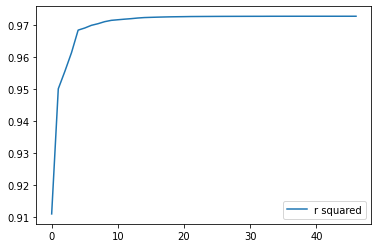

x_train.shape =  torch.Size([3066, 15, 1])
y_train.shape =  torch.Size([3066, 1])
x_test.shape =  torch.Size([35, 15, 1])
y_test.shape =  torch.Size([35, 1])
x_val.shape =  torch.Size([34, 15, 1])
y_val.shape =  torch.Size([34, 1])
LSTM(
  (lstm): LSTM(1, 32, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)
18
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])
Epoch  50 MSE:  0.13030028343200684
Epoch  50 Test MSE:  0.028857963159680367
Epoch  100 MSE:  0.1279752403497696
Epoch  100 Test MSE:  0.05299432948231697
Epoch  150 MSE:  0.12796713411808014
Epoch  150 Test MSE:  0.054553527384996414
--- 79.04106450080872 se

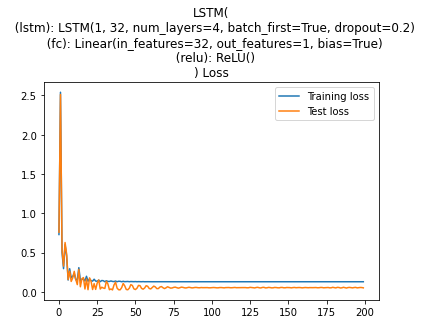

Test Score: 9.99 RMSE
Train Score: 23.62 RMSE
Validation Score: 11.25 RMSE


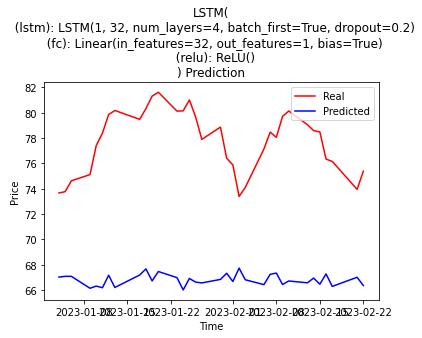

NameError: name 'step' is not defined

In [62]:


    
#Split data
#Train test validation splits
dat = dat.copy().drop(y_remove, axis=1)#.astype('float64')
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split_date(df = dat, target_col = y_name, dte = dte,
                                                                          val_days = val_days, test_days = val_days)

if verbose == True:
    print(dte)
    print("X_train: " + str(X_train.shape) + " " + str(min(X_train.index)) + ">" + str(max(X_train.index)))
    print("X_test: " + str(X_test.shape)+ " " + str(min(X_test.index)) + ">" + str(max(X_test.index)))
    print("X_val: " + str(X_val.shape)+ " " + str(min(X_val.index)) + ">" + str(max(X_val.index)))
    print("y_train: " + str(y_train.shape)+ " " + str(min(y_train.index)) + ">" + str(max(y_train.index)))
    print("y_test: " + str(y_test.shape)+ " " + str(min(y_test.index)) + ">" + str(max(y_test.index)))
    print("y_val: " + str(y_val.shape)+ " " + str(min(y_val.index)) + ">" + str(max(y_val.index)))

#Subset data 
X_train_vif, X_test_vif, X_val_vif = vif_correlation_subset(X_train, X_test, X_val, 
                                                            read_vif_values = read_vif_values, verbose = verbose)

X_train_subset, X_test_subset, X_val_subset, reg_model, subsets = fwd_subset(X_train_vif, X_test_vif, X_val_vif, 
                                                         y_train, y_name, verbose = verbose, 
                                                                    read_subset_values = read_subset_values)

#Create tensors from subset of data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_arr = scaler.fit_transform(X_train_subset)
X_val_arr = scaler.transform(X_val_subset)
X_test_arr = scaler.transform(X_test_subset)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

y_pred_train_reg = reg_model.predict(X_train_arr) 
y_pred_test_reg = reg_model.predict(X_test_arr) 
y_pred_val_reg = reg_model.predict(X_val_arr) 

import math
from sklearn.metrics import mean_squared_error
trainScoreReg = math.sqrt(mean_squared_error(y_train, y_pred_train_reg))
testScoreReg = math.sqrt(mean_squared_error(y_test, y_pred_test_reg))
valScoreReg = math.sqrt(mean_squared_error(y_val, y_pred_val_reg))

if verbose == True:
    print('Regression Train Score: %.2f RMSE' % (trainScoreReg))
    print('Regression Test Score: %.2f RMSE' % (testScoreReg))
    print('Regression Validation Score: %.2f RMSE' % (valScoreReg))

    plt.plot(subsets["r_sq"], label="r squared")
    plt.legend()
    plt.show()

# make training and test sets in torch
X_train_subset_tensor = torch.from_numpy(X_train_arr).type(torch.Tensor)
X_test_subset_tensor = torch.from_numpy(X_test_arr).type(torch.Tensor)
X_val_subset_tensor = torch.from_numpy(X_val_arr).type(torch.Tensor)
y_train_tensor = torch.from_numpy(y_train_arr).type(torch.Tensor)
y_test_tensor = torch.from_numpy(y_test_arr).type(torch.Tensor)
y_val_tensor = torch.from_numpy(y_val_arr).type(torch.Tensor)

X_train_subset_tensor = X_train_subset_tensor[:,:,None]
X_test_subset_tensor = X_test_subset_tensor[:,:,None]
X_val_subset_tensor = X_val_subset_tensor[:,:,None]

if verbose == True:
    print('x_train.shape = ',X_train_subset_tensor.shape)
    print('y_train.shape = ',y_train_tensor.shape)
    print('x_test.shape = ',X_test_subset_tensor.shape)
    print('y_test.shape = ',y_test_tensor.shape)
    print('x_val.shape = ',X_val_subset_tensor.shape)
    print('y_val.shape = ',y_val_tensor.shape)

if model_name == "lstm":
    model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
              num_layers=num_layers, dropout_prob = dropout)
elif model_name == "gru":
    model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
elif model_name == "rnn":
    model = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
                      layer_dim=num_layers, dropout_prob = dropout)

model = prune_model_l1_unstructured(model, nn.Conv2d, prune_prop)

loss_fn = torch.nn.L1Loss()

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

if verbose == True:
    print(model)
    print(len(list(model.parameters())))
    for i in range(len(list(model.parameters()))):
        print(list(model.parameters())[i].size())

model = prune_model_l1_unstructured(model, nn.Conv2d, prune_prop)

# Train model
#####################
hist = np.zeros(num_epochs)
hist_test = np.zeros(num_epochs)
look_back = 10 # choose sequence length

# Number of steps to unroll
seq_dim = look_back-1  

start_time = time.time() 
for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(X_train_subset_tensor)
    y_test_pred = model(X_test_subset_tensor)

    loss = loss_fn(y_train_pred, y_train_tensor)
    loss_test = loss_fn(y_test_pred, y_test_tensor)
    if verbose == True:
        if t % 50 == 0 and t !=0:
            print("Epoch ", t, "MSE: ", loss.item())
            print("Epoch ", t, "Test MSE: ", loss_test.item())
    hist[t] = loss.item()
    hist_test[t] = loss_test.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

if verbose == True:
    print("--- %s seconds ---" % (time.time() - start_time))

if verbose == True:
    plt.plot(hist, label="Training loss")
    plt.plot(hist_test, label="Test loss")
    plt.legend()
    plt.title(str(model) + " Loss")
    plt.savefig('lstm_loss_low.png')
    plt.show()

# make test predictions
y_test_pred = model(X_test_subset_tensor)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train_det = scaler.inverse_transform(y_train_tensor.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test_det = scaler.inverse_transform(y_test_tensor.detach().numpy())

# make validation predictions
y_val_pred = model(X_val_subset_tensor)

# invert predictions
y_val_pred = scaler.inverse_transform(y_val_pred.detach().numpy())
y_val_det = scaler.inverse_transform(y_val_tensor.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_det[:,0], y_train_pred[:,0]))
testScore = math.sqrt(mean_squared_error(y_test_det[:,0], y_test_pred[:,0]))
valScore = math.sqrt(mean_squared_error(y_val_det[:,0], y_val_pred[:,0]))

if verbose == True:
    print('Test Score: %.2f RMSE' % (testScore))
    print('Train Score: %.2f RMSE' % (trainScore))
    print('Validation Score: %.2f RMSE' % (valScore))

    # Visualising the results
    figure, axes = plt.subplots()
    axes.xaxis_date()

    axes.plot(pd.to_datetime(y_val.index), y_val.values, color = 'red', label = 'Real')
    axes.plot(pd.to_datetime(y_val.index), y_val_pred, color = 'blue', label = 'Predicted')
    plt.title(str(model) + ' Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.savefig('lstm.png')
    plt.show()

err_row = pd.DataFrame(data = {"reg_train":trainScoreReg,"reg_test":testScoreReg, "reg_val":valScoreReg,
      "net_train":trainScore,"net_test":testScore, "net_val":valScore#,
        #"hist":hist,"hist_test":hist_test,"y_test_pred":y_test_pred, "y_val_pred":y_val_pred
                              }, index = [str(dte)])

fcst = pd.DataFrame(data = {"dte" : y_val.index, "step": [step] * len(y_val_pred), "y_pred": y_val_pred, "y_val": y_val.values})

return(hist, hist_test, y_test_pred, y_val_pred, err_row, fcst)


In [88]:
step = 1
fcst = pd.DataFrame(index =  data = {"dte" : y_val.index.to_list(), "step":[step] * len(y_val_pred), 
                            "y_pred": y_val_pred.flatten(), "y_val": y_val.values.flatten()})
fcst

,dte,step,y_pred,y_val
0,2023-01-04,1,67.028557,73.669998
1,2023-01-05,1,67.088387,73.769997
2,2023-01-06,1,67.087997,74.629997
3,2023-01-09,1,66.144623,75.120003
4,2023-01-10,1,66.317917,77.410004
5,2023-01-11,1,66.189949,78.389999
6,2023-01-12,1,67.173187,79.860001
7,2023-01-13,1,66.208755,80.180000
8,2023-01-17,1,67.192780,79.480003
9,2023-01-18,1,67.674561,80.330002


In [91]:
fcst.insert(0, step_dte = )

TypeError: unsupported operand type(s) for +: 'datetime.datetime' and 'int'

In [103]:
fcst.index = fcst["step"].astype(str) + "_" + fcst["dte"]
fcst

,dte,step,y_pred,y_val,step_dte
1_2023-01-04,2023-01-04,1,67.028557,73.669998,12023-01-04
1_2023-01-05,2023-01-05,1,67.088387,73.769997,12023-01-05
1_2023-01-06,2023-01-06,1,67.087997,74.629997,12023-01-06
1_2023-01-09,2023-01-09,1,66.144623,75.120003,12023-01-09
1_2023-01-10,2023-01-10,1,66.317917,77.410004,12023-01-10
1_2023-01-11,2023-01-11,1,66.189949,78.389999,12023-01-11
1_2023-01-12,2023-01-12,1,67.173187,79.860001,12023-01-12
1_2023-01-13,2023-01-13,1,66.208755,80.180000,12023-01-13
1_2023-01-17,2023-01-17,1,67.192780,79.480003,12023-01-17
1_2023-01-18,2023-01-18,1,67.674561,80.330002,12023-01-18


In [87]:
y_val.values.flatten()

array([73.66999817, 73.76999664, 74.62999725, 75.12000275, 77.41000366,
       78.38999939, 79.86000061, 80.18000031, 79.48000336, 80.33000183,
       81.30999756, 81.62000275, 80.12999725, 80.15000153, 81.01000214,
       79.68000031, 77.90000153, 78.87000275, 76.41000366, 75.87999725,
       73.38999939, 74.11000061, 77.13999939, 78.47000122, 78.05999756,
       79.72000122, 80.13999939, 79.05999756, 78.58999634, 78.48999786,
       76.33999634, 76.16000366, 73.94999695, 75.38999939])

In [33]:
#Train test validation splits
y_name = "tgt_crd"
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split_date(dat, y_name, dte = forecast_start_date)
y_val_low = y_val
print("X_train: " + str(X_train.shape) + " " + str(min(X_train.index)) + ">" + str(max(X_train.index)))
print("X_test: " + str(X_test.shape)+ " " + str(min(X_test.index)) + ">" + str(max(X_test.index)))
print("X_val: " + str(X_val.shape)+ " " + str(min(X_val.index)) + ">" + str(max(X_val.index)))
print("y_train: " + str(y_train.shape)+ " " + str(min(y_train.index)) + ">" + str(max(y_train.index)))
print("y_test: " + str(y_test.shape)+ " " + str(min(y_test.index)) + ">" + str(max(y_test.index)))
print("y_val: " + str(y_val.shape)+ " " + str(min(y_val.index)) + ">" + str(max(y_val.index)))

X_train: (3105, 313) 2010-10-26>2023-03-01
X_test: (35, 313) 2023-04-21>2023-06-09
X_val: (35, 313) 2023-03-02>2023-04-20
y_train: (3105, 1) 2010-10-26>2023-03-01
y_test: (35, 1) 2023-04-21>2023-06-09
y_val: (35, 1) 2023-03-02>2023-04-20


In [46]:
X_train_vif, X_test_vif, X_val_vif = vif_correlation_subset(X_train, X_test, X_val, read_vif_values = False, verbose = True)

Open_crd
0


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF   feature
0  11.359712  Open_crd
Removing Open_crd
Volume_crd
1


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
   VIF     feature
1  inf  Volume_crd
Removing Volume_crd
Open_sp
2


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF  feature
2  154.595201  Open_sp
Removing Open_sp
Volume_sp
3


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
   VIF    feature
3  inf  Volume_sp
Removing Volume_sp
Volume_ns
4


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF    feature
4  97.163345  Volume_ns
Removing Volume_ns
Open_usd
5


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
        VIF   feature
5  17.03007  Open_usd
Removing Open_usd
Volume_usd
6


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
   VIF     feature
6  inf  Volume_usd
Removing Volume_usd
WB_NGAS_EUR
7


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF      feature
7  29.101138  WB_NGAS_EUR
Removing WB_NGAS_EUR
WB_IRON_ORE
8


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
        VIF      feature
8  5.303968  WB_IRON_ORE
WB_NGAS_US
9


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
        VIF     feature
9  6.836182  WB_NGAS_US
CON_DE_B-D_F
10


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF       feature
10  51.031759  CON_DE_B-D_F
Removing CON_DE_B-D_F
CON_DE_F
11


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
           VIF   feature
11  417.964048  CON_DE_F
Removing CON_DE_F
CON_DE_F_CC1
12


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
           VIF       feature
12  276.625066  CON_DE_F_CC1
Removing CON_DE_F_CC1
CON_DE_F_CC2
13


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF       feature
13  20.934035  CON_DE_F_CC2
Removing CON_DE_F_CC2
ELC_GAS
14


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
            VIF  feature
14  1180.284939  ELC_GAS
Removing ELC_GAS
TOT_X_ALC_TBC
15


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
            VIF        feature
15  5134.118751  TOT_X_ALC_TBC
Removing TOT_X_ALC_TBC
BS-CCI-BAL
16


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF     feature
16  5.648305  BS-CCI-BAL
BS-CSMCI-BAL
17


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF       feature
17  24.700748  BS-CSMCI-BAL
Removing BS-CSMCI-BAL
BS-ICI-BAL
18


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF     feature
18  4.437072  BS-ICI-BAL
BS-RCI-BAL
19


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF     feature
19  5.777116  BS-RCI-BAL
BS-SCI-BAL
20


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF     feature
20  9.549958  BS-SCI-BAL
diff_Open_crd
21


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF        feature
21  4.548249  diff_Open_crd
diff_High_crd
22


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF        feature
22  3.322703  diff_High_crd
diff_Low_crd
23


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF       feature
23  6.110452  diff_Low_crd
diff_Close_crd
24


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF         feature
24  6.776389  diff_Close_crd
diff_Volume_crd
25


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
    VIF          feature
25  inf  diff_Volume_crd
Removing diff_Volume_crd
diff_Open_sp
26


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF       feature
26  9.341306  diff_Open_sp
diff_High_sp
27


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF       feature
27  16.838185  diff_High_sp
Removing diff_High_sp
diff_Low_sp
28


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF      feature
28  19.526597  diff_Low_sp
Removing diff_Low_sp
diff_Close_sp
29


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF        feature
29  26.39771  diff_Close_sp
Removing diff_Close_sp
diff_Volume_sp
30


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
    VIF         feature
30  inf  diff_Volume_sp
Removing diff_Volume_sp
diff_Open_ns
31


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF       feature
31  9.977803  diff_Open_ns
diff_High_ns
32


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF       feature
32  17.96036  diff_High_ns
Removing diff_High_ns
diff_Low_ns
33


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF      feature
33  18.550455  diff_Low_ns
Removing diff_Low_ns
diff_Close_ns
34


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF        feature
34  25.186502  diff_Close_ns
Removing diff_Close_ns
diff_Volume_ns
35


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF         feature
35  3.326537  diff_Volume_ns
diff_Open_usd
36


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF        feature
36  2.906929  diff_Open_usd
diff_High_usd
37


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF        feature
37  2.797991  diff_High_usd
diff_Low_usd
38


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF       feature
38  3.123294  diff_Low_usd
diff_Close_usd
39


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF         feature
39  3.319502  diff_Close_usd
diff_Volume_usd
40


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
    VIF          feature
40  inf  diff_Volume_usd
Removing diff_Volume_usd
diff_WB_CRUDE_BRENT
41


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF              feature
41  4.734214  diff_WB_CRUDE_BRENT
diff_WB_NGAS_EUR
42


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF           feature
42  1.883728  diff_WB_NGAS_EUR
diff_WB_IRON_ORE
43


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF           feature
43  1.598003  diff_WB_IRON_ORE
diff_WB_NGAS_US
44


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF          feature
44  1.891854  diff_WB_NGAS_US
diff_CON_DE_B-D_F
45


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF            feature
45  5.080728  diff_CON_DE_B-D_F
diff_CON_DE_F
46


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF        feature
46  10.805046  diff_CON_DE_F
Removing diff_CON_DE_F
diff_CON_DE_F_CC2
47


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF            feature
47  6.015148  diff_CON_DE_F_CC2
diff_ELC_GAS
48


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
           VIF       feature
48  114.488923  diff_ELC_GAS
Removing diff_ELC_GAS
diff_IGD
49


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF   feature
49  9.898329  diff_IGD
diff_NRG
50


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF   feature
50  419.04501  diff_NRG
Removing diff_NRG
diff_TOT_X_ALC_TBC
51


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
           VIF             feature
51  2004.94864  diff_TOT_X_ALC_TBC
Removing diff_TOT_X_ALC_TBC
diff_TOT_X_FROOPP
52


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
           VIF            feature
52  158.724372  diff_TOT_X_FROOPP
Removing diff_TOT_X_FROOPP
diff_TOT_X_FUEL
53


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
            VIF          feature
53  1466.935646  diff_TOT_X_FUEL
Removing diff_TOT_X_FUEL
diff_TOT_X_NRG_FOOD
54


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF              feature
54  203.10954  diff_TOT_X_NRG_FOOD
Removing diff_TOT_X_NRG_FOOD
diff_BS-CCI-BAL
55


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF          feature
55  3.940253  diff_BS-CCI-BAL
diff_BS-CSMCI-BAL
56


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF            feature
56  3.452427  diff_BS-CSMCI-BAL
diff_BS-ICI-BAL
57


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF          feature
57  3.684121  diff_BS-ICI-BAL
diff_BS-RCI-BAL
58


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF          feature
58  4.133318  diff_BS-RCI-BAL
diff_BS-SCI-BAL
59


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF          feature
59  4.775257  diff_BS-SCI-BAL
diff_Price
60


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF     feature
60  1.425336  diff_Price
ravg_qt_Volume_crd
61


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF             feature
61  25.192153  ravg_qt_Volume_crd
Removing ravg_qt_Volume_crd
ravg_qt_Volume_sp
62


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
           VIF            feature
62  470.706916  ravg_qt_Volume_sp
Removing ravg_qt_Volume_sp
ravg_qt_Volume_usd
63


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF             feature
63  3.489298  ravg_qt_Volume_usd
ravg_yr_Volume_crd
64


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
        VIF             feature
64  8.45045  ravg_yr_Volume_crd
ravg_yr_Volume_sp
65


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
           VIF            feature
65  191.944859  ravg_yr_Volume_sp
Removing ravg_yr_Volume_sp
ravg_yr_Volume_usd
66


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF             feature
66  1.551189  ravg_yr_Volume_usd
ravg_yr_CON_DE_B-D_F
67


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF               feature
67  42.649737  ravg_yr_CON_DE_B-D_F
Removing ravg_yr_CON_DE_B-D_F
ravg_yr_CON_DE_F
68


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
           VIF           feature
68  342.130607  ravg_yr_CON_DE_F
Removing ravg_yr_CON_DE_F
ravg_yr_CON_DE_F_CC1
69


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
           VIF               feature
69  231.996821  ravg_yr_CON_DE_F_CC1
Removing ravg_yr_CON_DE_F_CC1
lag_Volume_crd
70


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
    VIF         feature
70  inf  lag_Volume_crd
Removing lag_Volume_crd
lag_Volume_sp
71


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
    VIF        feature
71  inf  lag_Volume_sp
Removing lag_Volume_sp
lag_Volume_usd
72


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
    VIF         feature
72  inf  lag_Volume_usd
Removing lag_Volume_usd
yoy_Open_crd
73


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF       feature
73  11.651644  yoy_Open_crd
Removing yoy_Open_crd
yoy_Low_crd
74


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF      feature
74  11.55793  yoy_Low_crd
Removing yoy_Low_crd
yoy_Volume_crd
75


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF         feature
75  2.441515  yoy_Volume_crd
yoy_Open_sp
76


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF      feature
76  10.081124  yoy_Open_sp
Removing yoy_Open_sp
yoy_Volume_sp
77


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF        feature
77  4.127795  yoy_Volume_sp
yoy_Open_ns
78


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF      feature
78  9.516895  yoy_Open_ns
yoy_Volume_ns
79


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF        feature
79  3.354049  yoy_Volume_ns
yoy_Open_usd
80


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF       feature
80  1.520772  yoy_Open_usd
yoy_Volume_usd
81


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF         feature
81  2.057717  yoy_Volume_usd
yoy_WB_CRUDE_BRENT
82


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF             feature
82  5.208057  yoy_WB_CRUDE_BRENT
yoy_WB_NGAS_EUR
83


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
       VIF          feature
83  2.3054  yoy_WB_NGAS_EUR
yoy_WB_IRON_ORE
84


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF          feature
84  2.085525  yoy_WB_IRON_ORE
yoy_WB_NGAS_US
85


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF         feature
85  2.261589  yoy_WB_NGAS_US
yoy_CON_DE_B-D_F
86


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF           feature
86  10.41785  yoy_CON_DE_B-D_F
Removing yoy_CON_DE_B-D_F
yoy_CON_DE_F
87


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF       feature
87  17.146642  yoy_CON_DE_F
Removing yoy_CON_DE_F
yoy_CON_DE_F_CC2
88


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF           feature
88  10.009637  yoy_CON_DE_F_CC2
Removing yoy_CON_DE_F_CC2
yoy_ELC_GAS
89


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
           VIF      feature
89  134.432322  yoy_ELC_GAS
Removing yoy_ELC_GAS
yoy_IGD
90


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF  feature
90  10.913706  yoy_IGD
Removing yoy_IGD
yoy_NRG
91


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
           VIF  feature
91  497.916283  yoy_NRG
Removing yoy_NRG
yoy_TOT_X_ALC_TBC
92


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
            VIF            feature
92  2182.331698  yoy_TOT_X_ALC_TBC
Removing yoy_TOT_X_ALC_TBC
yoy_TOT_X_FROOPP
93


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
           VIF           feature
93  179.026744  yoy_TOT_X_FROOPP
Removing yoy_TOT_X_FROOPP
yoy_TOT_X_FUEL
94


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
            VIF         feature
94  1565.979572  yoy_TOT_X_FUEL
Removing yoy_TOT_X_FUEL
yoy_TOT_X_NRG_FOOD
95


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
           VIF             feature
95  232.624399  yoy_TOT_X_NRG_FOOD
Removing yoy_TOT_X_NRG_FOOD
yoy_BS-CCI-BAL
96


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF         feature
96  4.925976  yoy_BS-CCI-BAL
yoy_BS-CSMCI-BAL
97


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
        VIF           feature
97  4.26224  yoy_BS-CSMCI-BAL
yoy_BS-ICI-BAL
98


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF         feature
98  4.548438  yoy_BS-ICI-BAL
yoy_BS-RCI-BAL
99


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
         VIF         feature
99  4.754283  yoy_BS-RCI-BAL
yoy_BS-SCI-BAL
100


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF         feature
100  6.114753  yoy_BS-SCI-BAL
yoy_Price
101


C:\Users\lawre\anaconda3\envs\gpu2\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            VIF           feature
0     11.359712          Open_crd
1           inf        Volume_crd
2    154.595201           Open_sp
3           inf         Volume_sp
4     97.163345         Volume_ns
..          ...               ...
97     4.262240  yoy_BS-CSMCI-BAL
98     4.548438    yoy_BS-ICI-BAL
99     4.754283    yoy_BS-RCI-BAL
100    6.114753    yoy_BS-SCI-BAL
101    1.887148         yoy_Price

[102 rows x 2 columns]
          VIF    feature
101  1.887148  yoy_Price


KeyError: "['yoy_TOT_X_FUEL', 'diff_High_ns', 'CON_DE_F_CC2', 'CON_DE_B-D_F', 'yoy_Low_crd', 'Volume_crd', 'lag_Volume_crd', 'Volume_ns', 'diff_ELC_GAS', 'diff_Low_sp', 'diff_NRG', 'BS-CSMCI-BAL', 'diff_Volume_crd', 'diff_Volume_sp', 'diff_TOT_X_ALC_TBC', 'yoy_TOT_X_NRG_FOOD', 'lag_Volume_sp', 'yoy_TOT_X_ALC_TBC', 'Volume_usd', 'diff_High_sp', 'Open_sp', 'yoy_ELC_GAS', 'lag_Volume_usd', 'diff_TOT_X_FUEL', 'ravg_yr_CON_DE_F', 'ravg_yr_CON_DE_F_CC1', 'CON_DE_F', 'ravg_qt_Volume_crd', 'yoy_Open_sp', 'Open_crd', 'yoy_Open_crd', 'TOT_X_ALC_TBC', 'WB_NGAS_EUR', 'yoy_NRG', 'ravg_yr_CON_DE_B-D_F', 'Open_usd', 'ravg_yr_Volume_sp', 'diff_Low_ns', 'yoy_CON_DE_F', 'diff_Close_sp', 'yoy_CON_DE_B-D_F', 'yoy_TOT_X_FROOPP', 'CON_DE_F_CC1', 'diff_Close_ns', 'diff_CON_DE_F', 'ELC_GAS', 'diff_TOT_X_FROOPP', 'Volume_sp', 'yoy_IGD', 'diff_TOT_X_NRG_FOOD', 'yoy_CON_DE_F_CC2', 'diff_Volume_usd', 'ravg_qt_Volume_sp'] not in index"

In [47]:
X_train_subset, X_test_subset, X_val, reg_model = fwd_subset(X_train_vif, X_test_vif, X_val_vif, 
                                                             y_train, y_name, verbose = True)

NameError: name 'X_train_vif' is not defined